In [1]:
import torch
import torchvision.models as models
from torch.autograd import Variable

In [2]:
alexnet = models.alexnet()
alexnet.cuda()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [3]:
from torchvis import util

In [4]:
layers_to_save = ('features.0', # input layers.
                 )

In [5]:
layer_dict, forward_hook_remove_func_list = util.prepare_module(alexnet, layers_to_save)

In [6]:
layer_dict

OrderedDict([('features.0', {'type': <LayerType.OTHER: 2>}),
             ('features.1', {'type': <LayerType.RELU: 1>}),
             ('features.4', {'type': <LayerType.RELU: 1>}),
             ('features.7', {'type': <LayerType.RELU: 1>}),
             ('features.9', {'type': <LayerType.RELU: 1>}),
             ('features.11', {'type': <LayerType.RELU: 1>}),
             ('classifier.2', {'type': <LayerType.RELU: 1>}),
             ('classifier.5', {'type': <LayerType.RELU: 1>})])

In [7]:
forward_hook_remove_func_list

In [8]:
alexnet

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [9]:
# ok. let's put in some images, and see what happens.
# let's just load some image
# this is the same image as in <https://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb>

In [10]:
from PIL import Image
import numpy as np
from torchvision import transforms

In [11]:
img_to_use = Image.open('./4334173592_145856d89b.jpg')
print(img_to_use.size)

(500, 355)


In [12]:
transform_1 = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
])

transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                          std = [ 0.229, 0.224, 0.225 ]),
])

img_to_use_cropped = transform_1(img_to_use)
img_to_use_cropped_tensor = transform_2(img_to_use_cropped)[np.newaxis]  # add first column for batching

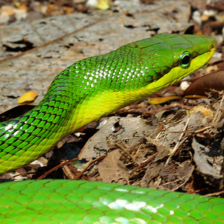

In [13]:
img_to_use_cropped  # this is same as Lasagne example.

In [14]:
alexnet(Variable(img_to_use_cropped_tensor.cuda()))

features.1 (1, 64, 55, 55)
features.4 (1, 192, 27, 27)
features.7 (1, 384, 13, 13)
features.9 (1, 256, 13, 13)
features.11 (1, 256, 13, 13)
classifier.2 (1, 4096)
classifier.5 (1, 4096)


Variable containing:
-1.3881e-02 -1.9995e-02 -3.9842e-03  ...  -4.8535e-03  1.8642e-02  2.3451e-03
[torch.cuda.FloatTensor of size 1x1000 (GPU 0)]

In [18]:
for x, y in layer_dict.items():
    if y['type'] == util.LayerType.RELU:
        print(x, y['output'].shape, y['output'].mean(), y['output'].std())

features.1 (1, 64, 55, 55) 0.241451 0.383665
features.4 (1, 192, 27, 27) 0.182219 0.268907
features.7 (1, 384, 13, 13) 0.104106 0.152116
features.9 (1, 256, 13, 13) 0.0446155 0.0612994
features.11 (1, 256, 13, 13) 0.0165157 0.0259199
classifier.2 (1, 4096) 0.0152572 0.0215082
classifier.5 (1, 4096) 0.00958988 0.0139359
